<a href="https://colab.research.google.com/github/Tucker6742/DeepLearning/blob/main/DeepLearning_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\text{Download dataset}$

In [ ]:
%cd /root/.kaggle
!touch kaggel.json

/root/.kaggle


In [ ]:
# %%writefile kaggle.json
# {"username":"theunkovvn","key":"ba064e9386e385cc1042c624ed089930"}

Writing kaggle.json


In [ ]:
# !cat kaggle.json

{"username":"theunkovvn","key":"ba064e9386e385cc1042c624ed089930"}


In [ ]:
# !chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# %cd /content

/content


In [ ]:
!kaggle competitions download -c dogs-vs-cats -p /content

100% 810M/812M [00:31<00:00, 29.1MB/s]
100% 812M/812M [00:31<00:00, 27.3MB/s]


In [ ]:
# !unzip /content/dogs-vs-cats.zip
# !rm /content/dogs-vs-cats.zip

In [ ]:
!unzip "*.zip"
!rm *.zip

Archive:  train.zip
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# $\text{Import library}$

In [60]:
!pip install --force-reinstall -v polars==0.19.12
!pip install torchsummary
!python -m pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 49.7 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path

In [61]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchsummary import summary
import lightning.pytorch as ptl
import torch.nn.functional as F
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

# $\text{Sample image}$

## $\text{Train folder}$

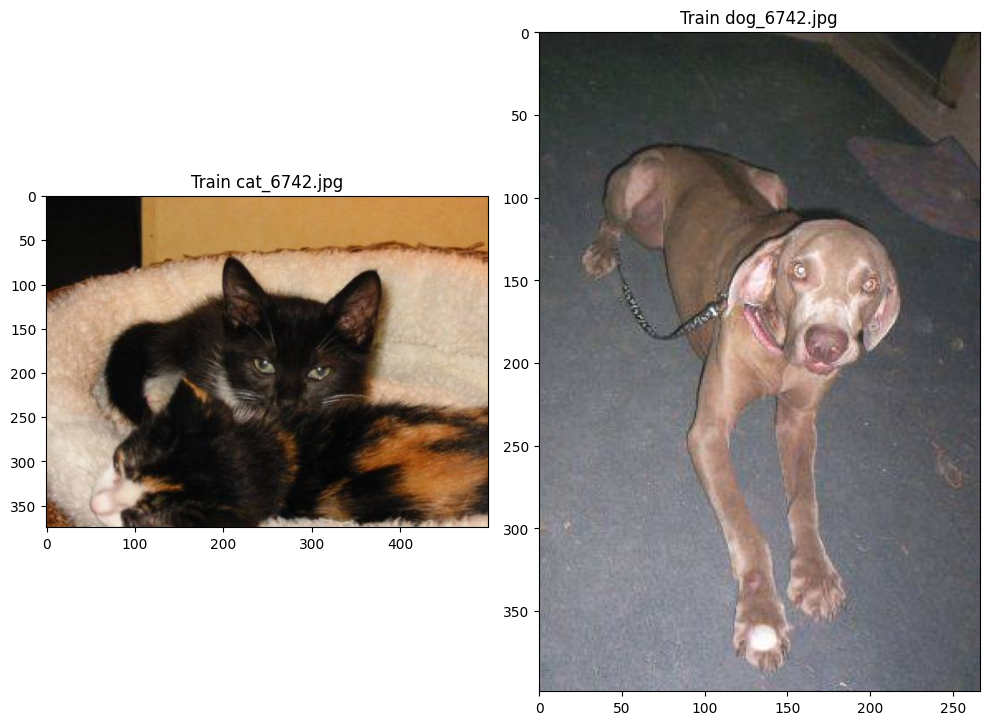

In [19]:
train_cat_sample = Image.open("/content/train/cat.6742.jpg")
train_dog_sample = Image.open("/content/train/dog.6742.jpg")

fig_train, ax_train = plt.subplots(1, 2, figsize=[10,10])

ax_train[0].imshow(train_cat_sample)
ax_train[0].set_title("Train cat_6742.jpg")
ax_train[1].imshow(train_dog_sample)
ax_train[1].set_title("Train dog_6742.jpg")

fig_train.tight_layout()
fig_train.show()

# $\text{Get train dataframe (img_link/class)}$

In [20]:
train_dir = list(map(str,list(Path("/content/train").glob("*.jpg"))))

In [49]:
train_dir[0]

'/content/train/dog.10373.jpg'

In [50]:
train_df = pl.DataFrame(train_dir)

In [51]:
class_df = train_df.select(
    pl.col("column_0").str.split('/')
    .list.to_struct(n_field_strategy="max_width")
).unnest('column_0')[:,-1]
class_df = class_df.to_frame().select(
    pl.col("field_3").str.split(".").list.to_struct()
).unnest("field_3")[:, 0]

In [64]:
train_df = train_df.with_columns(
    class_df == "dog"
)
train_df = train_df.rename(
    {
        "field_0": "class",
        "column_0":"img_link"
    }
)
train_df = train_df.cast({"class": pl.Int32})

In [68]:
print(train_df)

shape: (25_000, 2)
┌──────────────────────────────┬───────┐
│ img_link                     ┆ class │
│ ---                          ┆ ---   │
│ str                          ┆ i32   │
╞══════════════════════════════╪═══════╡
│ /content/train/dog.10373.jpg ┆ 1     │
│ /content/train/dog.794.jpg   ┆ 1     │
│ /content/train/cat.2411.jpg  ┆ 0     │
│ /content/train/dog.8288.jpg  ┆ 1     │
│ …                            ┆ …     │
│ /content/train/cat.9435.jpg  ┆ 0     │
│ /content/train/dog.12239.jpg ┆ 1     │
│ /content/train/cat.3831.jpg  ┆ 0     │
│ /content/train/cat.4194.jpg  ┆ 0     │
└──────────────────────────────┴───────┘


# $\text{Config class}$

In [72]:
class Config:
    def __init__(self):
        self.train_split = 0.7
        self.val_split = 0.2

In [73]:
config = Config()

# $\text{Create dataset, dataloader}$

In [67]:
class CatDog_Dataset(Dataset):
    def __init__(self, train_df):
        self.train_df = train_df
    def __len__(self):
        return len(self.train_df)
    def __getitem__(self, idx):
        image = self.get_image(idx)
        label = self.train_df[idx,1]
        return image, label
    def get_image(self, idx):
        im_path = self.train_df[idx,0]
        image = Image.open(im_path)
        pixel_np = np.array(image)
        process = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        input_tensor = process(image)
        return input_tensor

In [69]:
class Dataset_config:
    def __init__(self, _train_df):
        self.data_dataset = CatDog_Dataset(_train_df)

        self.train_size = int(config.train_split*len(self.data_dataset))
        self.val_size = int(config.val_split*len(self.data_dataset))
        self.test_size = len(self.data_dataset) - self.train_size - self.val_size

        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(self.data_dataset, [self.train_size,self.val_size, self.test_size])
        self.train_dataset = self.train_dataset.dataset
        self.val_dataset = self.val_dataset.dataset
        self.test_dataset = self.test_dataset.dataset

        self.train_dataloader = DataLoader(self.train_dataset, batch_size = 64, shuffle = True)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size = 64, shuffle = False)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=64, shuffle=True)




In [74]:
DATASET = Dataset_config(train_df)

# $\text{Set up model}$

In [ ]:
resnext_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', weights=True)

In [ ]:


class Base_Pytorch_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnext_model
        self.backbone.requires_grad = False
        self.classif_list = nn.Sequential(
                    nn.Linear(1000, 512),
                    nn.Linear(512, 256),
                    nn.Linear(256, 64),
                    nn.Linear(64, 2)
                )
    def forward(self, image):
        image = image.type(torch.FloatTensor).cuda()
        resnext_processed = self.backbone(image)
        result = self.classif_list(resnext_processed)
        return result



# $\text{Traning step}$

In [76]:
class Lightning_Wrapper(ptl.LightningModule):
    def __init__(self, model_, lr_):
        super().__init__()
        self.model = model_
        self.learning_rate = lr_

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        image, label = batch
        label = [x.cuda() for x in label]
        result = self(image)
        loss = F.cross_entropy(result, label)

        correct = result.argmax(axis = -1) == label

        logs = {
                "acc_tr": correct.count_nonzero().item()/len(image)*100,
               }
        self.log_dict(logs)
        self.log("loss_tr", loss,  prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        image, label = batch
        label = [x.cuda() for x in label]
        result = self(image)
        loss = F.cross_entropy(result, label)

        correct = result.argmax(axis = -1) == label

        logs = {
                "acc_va": correct.count_nonzero().item()/len(image)*100,
               }
        self.log_dict(logs)
        self.log("loss_va", loss,  prog_bar=True)
        return loss

#     def validation_dataloader(self):
#         return DATASET.val_dataloader

    def test_step(self, batch, batch_idx):
        image, label = batch
        label = [x.cuda() for x in label]
        result = self(image)
        loss = F.cross_entropy(result, label)

        correct = result.argmax(axis = -1) == label

        logs = {
                "acc_test": correct.count_nonzero().item()/len(image)*100,
               }
        self.log_dict(logs)
        self.log("loss_test", loss,  prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
logger = TensorBoardLogger("/kaggle/working/lightning_logs/",
                           name="",
                           version=0
                          )
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="loss_tr",
    mode="min",
    dirpath="/kaggle/working/lightning_logs/version_0/checkpoints/",
    filename="model-{epoch:02d}-{loss_tr}",
    verbose = True,
    every_n_train_steps = 500,
)

trainer = ptl.Trainer(
#     fast_dev_run = True,
    max_epochs = 10,
    callbacks=[
        LearningRateFinder(),
        checkpoint_callback
    ],
    profiler="simple",
    accelerator="auto",
    accumulate_grad_batches=6,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val = 0.0000001,
    logger = logger,
)
base_model = Base_Pytorch_Model()
lightning_model = Lightning_Wrapper(base_model, config.lr)

trainer.fit(lightning_model,
            train_dataloaders = DATASET.train_dataloader,
            val_dataloaders = DATASET.val_dataloader,
           )